## Import & Process Image

In [62]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import SGD, Adam

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import glob

# from src.functions import preprocess_image, load_and_preprocess_image

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## Pipeline with Sampleset

In [2]:
def preprocess_image(image, imgage_shape=[100,100]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, imgage_shape)
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

In [5]:
def import_dataset(img_path, data_path):
    img_url = sorted(glob.glob(img_path+"/*.jpg"))
    csv_names = [i for i in glob.glob(data_path+'/*.csv')]
    df = pd.concat([pd.read_csv(f) for f in csv_names]).sort_values('name').reset_index(drop=True)
    df['image'] = img_url
    return df

def clean_dataset(df):
    dataset = df.copy()
    dataset = dataset[['meta.clinical.diagnosis', 'image']]
    dataset = dataset[dataset['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
    dataset.columns = ['diagnosis', 'image']
    dataset['diagnosis'] = (dataset['diagnosis'] == 'melanoma').astype(int)
    return dataset

def create_X_y(df):
    y = df['diagnosis']
    X = []
    for i in df['image']:
        image = load_and_preprocess_image(i)
        X.append(np.asarray(image))
    return np.asarray(X), np.asarray(y)

#### Creating Test Set

In [6]:
# Importing and creating test set. Returns X & y.
test_df = import_dataset('img_sample/img_test','data_sample/data_test')
test_df_cleaned = clean_dataset(test_df)
X_test, y_test = create_X_y(test_df_cleaned)

#### Creating Train Set

In [7]:
# Train Set
path = "img_sample/img_train"
negataive_img_names = sorted(glob.glob(path+"/0/*.jpg"))
positive_img_names = sorted(glob.glob(path+"/1/*.jpg"))

negative_csv =[i for i in glob.glob('data_sample/data_train/0/*.csv')]
positive_csv =[i for i in glob.glob('data_sample/data_train/1/*.csv')]

train_neg = pd.concat([pd.read_csv(f) for f in negative_csv]).sort_values('name').reset_index(drop=True)
train_pos = pd.concat([pd.read_csv(f) for f in positive_csv]).sort_values('name').reset_index(drop=True)

train_neg['image'] = negataive_img_names
train_pos['image'] = positive_img_names

In [8]:
# Train Set
meta_train = pd.concat([train_neg, train_pos]).reset_index(drop=True)
lbl_img = meta_train[['meta.clinical.diagnosis', 'image']]
lbl_img_cl = lbl_img[lbl_img['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
lbl_img_cl.columns = ['diagnosis', 'image']
lbl_img_cl['diagnosis'] = (lbl_img_cl['diagnosis'] == 'melanoma').astype(int)
fileimages = lbl_img_cl['image']

In [20]:
## Create X and y for Train set. You only need to run this once!
# y = np.asarray(lbl_img_cl['diagnosis'])
# X = []
# for i in fileimages:
#     image = load_and_preprocess_image(i)
#     X.append(np.asarray(image))
# X = np.asarray(X)

#### Saving converted images to numpy file

In [23]:
# np.save('img_sample/test100x100.npy', X)

In [24]:
X = np.load('img_sample/test100x100.npy')
y = np.asarray(lbl_img_cl['diagnosis'])

In [29]:
# Train/test split for Train Set
X_train, X_val, y_train, y_val = train_test_split(np.asarray(X), np.asarray(y), test_size=0.2, random_state=42, stratify=y)

#### Train Model

In [63]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [64]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall()])

In [65]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
25/25 [==============================] - 3s 125ms/step - loss: 0.6915 - accuracy: 0.5201 - recall: 0.5175 - val_loss: 0.8072 - val_accuracy: 0.2567 - val_recall: 0.9870
Epoch 2/100
25/25 [==============================] - 3s 115ms/step - loss: 0.6492 - accuracy: 0.6253 - recall: 0.6475 - val_loss: 0.9946 - val_accuracy: 0.3400 - val_recall: 0.8442
Epoch 3/100
25/25 [==============================] - 3s 116ms/step - loss: 0.5977 - accuracy: 0.6892 - recall: 0.6850 - val_loss: 0.8764 - val_accuracy: 0.3667 - val_recall: 0.7532
Epoch 4/100
25/25 [==============================] - 3s 116ms/step - loss: 0.5541 - accuracy: 0.7306 - recall: 0.7600 - val_loss: 0.7999 - val_accuracy: 0.4567 - val_recall: 0.5325
Epoch 5/100
25/25 [==============================] - 3s 117ms/step - loss: 0.5545 - accuracy: 0.7243 - recall: 0.7100 - val_loss: 0.7524 - val_accuracy: 0.5100 - val_recall: 0.5065
Epoch 6/100
25/25 [==============================] - 3s 118ms/step - loss: 0.5235 - accuracy: 0

In [66]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

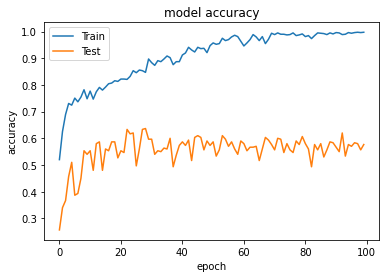

In [68]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

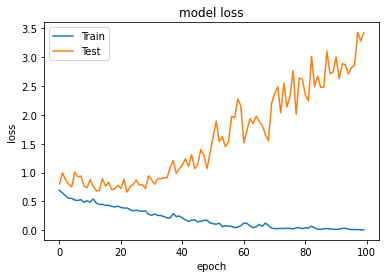

In [69]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

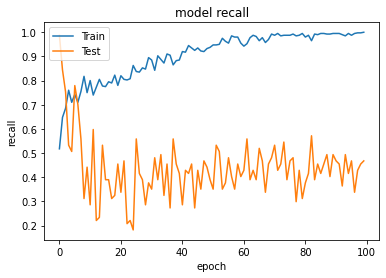

In [67]:
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [70]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 64)       

## Evalaution

In [77]:
# Validation Set
val_loss, val_acc, val_recall = model.evaluate(X_val, y_val, verbose=0)
print('Val  set accuracy {:5.2f}%'.format(100*val_acc))
print('Val  set recall   {:5.2f}%'.format(100*val_recall))

# Test Set
test_loss, test_acc, test_recall = model.evaluate(X_test, y_test, verbose=0)
print('Test set accuracy {:5.2f}%'.format(100*test_acc))
print('Test set recall   {:5.2f}%'.format(100*test_recall))


Val  set accuracy 78.50%
Val  set recall   81.00%
Test set accuracy 57.67%
Test set recall   46.75%


In [71]:
def matrix_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(np.array([[tp, fn],[fp, tn]]))
    print('Recall:    {:.3f}'.format(tp/(tp+fn)))
    print('Precision: {:.3f}'.format(tp/(tp+fp)))
    print('Accuracy:  {:.3f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('ROC AUC:   {:.3f}'.format(roc_auc_score(y_test, y_pred)))

In [79]:
threshold = 0.5

In [80]:
# Validation Set
result = (model.predict(X_val) > threshold).astype(int)
result =[i[0] for i in result]
y_val_pred = np.asarray(result)

matrix_score(y_val, y_val_pred)

[[81 19]
 [24 76]]
Recall:    0.810
Precision: 0.771
Accuracy:  0.785
ROC AUC:   0.785


In [81]:
# Test Set
result = (model.predict(X_test) > threshold).astype(int)
result =[i[0] for i in result]
y_test_pred = np.asarray(result)

matrix_score(y_test, y_test_pred)

[[ 36  41]
 [ 86 137]]
Recall:    0.468
Precision: 0.295
Accuracy:  0.577
ROC AUC:   0.541


## ROC AUC Curve

In [86]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

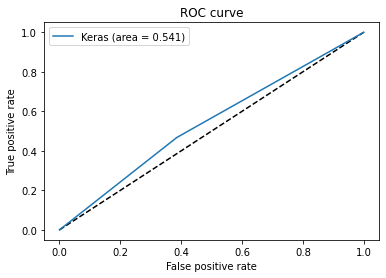

In [96]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_test_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

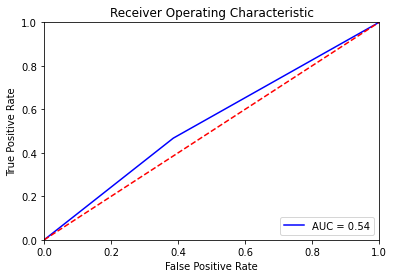

In [97]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [245]:
## slicing the array of strings, resulting in a set of scalar binary-strings
path_ds = tf.data.Dataset.from_tensor_slices(fileimages)

## create a new dataset that loads and formats images on the fly
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

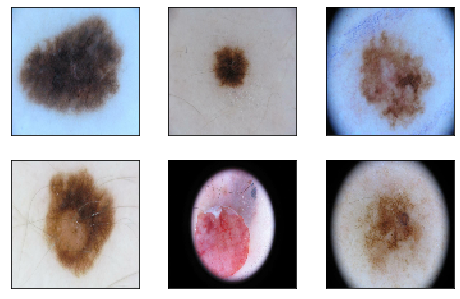

In [234]:
plt.figure(figsize = (8,8))
for n, image in enumerate(image_ds.take(6)):
    plt.subplot(3,3,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])